In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchsummary import *
from gman3 import *
import time
import datetime
os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f"Using device {device}")

Using device cuda:0


# Data

In [3]:
# log string
def log_string(log, string):
    log.write(string + '\n')
    log.flush()
    print(string)
# metric
def metric(pred, label):
    mask = torch.ne(label, 0)
    mask = mask.type(torch.float32)
    mask /= torch.mean(mask)
    mae = torch.abs(torch.sub(pred, label)).type(torch.float32)
    rmse = mae ** 2
    mape = mae / label
    mae = torch.mean(mae)
    rmse = rmse * mask
    rmse = torch.sqrt(torch.mean(rmse))
    mape = mape * mask
    mape = torch.mean(mape)
    return mae, rmse, mape

def seq2instance(data, P, Q):
    num_step, dims = data.shape
    num_sample = num_step - P - Q + 1
    x = torch.zeros(num_sample, P, dims)
    y = torch.zeros(num_sample, Q, dims)
    for i in range(num_sample):
        x[i] = data[i : i + P]
        y[i] = data[i + P : i + P + Q]
    return x, y

def loadData(data_args):
    # Traffic
    df = pd.read_csv(data_args['data_file'],index_col=0)
    Traffic = torch.from_numpy(df.values)
    # train/val/test 
    num_step = df.shape[0]
    train_steps = round(data_args['train_ratio'] * num_step)
    test_steps = round(data_args['test_ratio'] * num_step)
    val_steps = num_step - train_steps - test_steps
    train = Traffic[: train_steps]
    val = Traffic[train_steps : train_steps + val_steps]
    test = Traffic[-test_steps :]
    # X, Y 
    trainX, trainY = seq2instance(train, data_args['P'], data_args['Q'])
    valX, valY = seq2instance(val,data_args['P'], data_args['Q'])
    testX, testY = seq2instance(test,data_args['P'], data_args['Q'])
    # normalization
    mean, std = torch.mean(trainX), torch.std(trainX)
    trainX = (trainX - mean) / std
    valX = (valX - mean) / std
    testX = (testX - mean) / std
    
    # temporal embedding 
    time = pd.DatetimeIndex(df.index)
    dayofweek = torch.reshape(torch.tensor(time.weekday), (-1, 1))
#     timeofday = (time.hour * 3600 + time.minute * 60 + time.second) \
#                 // time.freq.delta.total_seconds()
#     timeofday = torch.reshape(torch.tensor(timeofday), (-1, 1))
    timeofday = (time.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
    timeofday = torch.reshape(torch.tensor(timeofday), (-1, 1))        
    time = torch.cat((dayofweek, timeofday), -1)
    # train/val/test
    train = time[: train_steps]
    val = time[train_steps : train_steps + val_steps]
    test = time[-test_steps :]
    # shape = (num_sample, P + Q, 2)
    trainTE = seq2instance(train,data_args['P'], data_args['Q'])
    trainTE = torch.cat(trainTE, 1).type(torch.int32)
    valTE = seq2instance(val, data_args['P'], data_args['Q'])
    valTE = torch.cat(valTE, 1).type(torch.int32)
    testTE = seq2instance(test, data_args['P'],data_args['Q'])
    testTE = torch.cat(testTE, 1).type(torch.int32)
    
    return (trainX, trainTE, trainY, valX, valTE, valY, testX, testTE, testY,
             mean, std)

In [4]:
data_args={
'data_file' : './Dataset/Wind/tj_wind_5m.csv',
# 'SE_file' : './Dataset/PEMS-BAY/SE(PeMS).txt',
'train_ratio' : 0.7,
'test_ratio' : 0.1,
'P' : 36,
'Q' : 12
}
(trainX, trainTE, trainY, valX, valTE, valY, testX, testTE, testY,
 mean, std) = loadData(data_args)
SE = torch.zeros((12,64))

In [5]:
print(trainX.shape)

torch.Size([73537, 36, 12])


# Model

In [6]:
nnodes = 12
ne = 3
ndim = 32
alpha = 0.5
L = 3
K = 8
d = 8
num_his = data_args['P']
num_pred = data_args['Q']
bn_decay =0.1
steps_per_day = 288
use_bias = False
mask = True
model = GMAN4(nnodes,ne,ndim,alpha,L,K,d,num_his,bn_decay,steps_per_day,use_bias,mask,SE,device).to(device)

In [7]:
# from torchsummary import *
# summary(model,input_size=[(12,325),(15,2)],batch_size=32)

# Train

In [8]:
max_epochs =100
patience =7
batch_size = 128
LR = 0.01
decay_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                      step_size=decay_epoch,
                                      gamma=0.9)
loss_criterion = nn.L1Loss().to(device)
model_file = './Model/GMAN/gman4_tjwind(1).pkl'

In [ ]:
log_file = './Dataset/Wind/log(tjWind)'
log = open(log_file, 'w')
log_string(log, '**** training model ****')
num_val = valX.shape[0]
num_train = trainX.shape[0]
# num_train = 800
num_test = testX.shape[0]
train_num_batch = math.ceil(num_train / batch_size)
val_num_batch = math.ceil(num_val / batch_size)
test_num_batch = math.ceil(num_test / batch_size)
wait = 0
val_loss_min = float('inf')
best_model_wts = None
train_total_loss = []
val_total_loss = []
# shuffle
SE = SE.to(device)
# model = torch.load(model_file)
for epoch in range(max_epochs):    
    if wait >= patience:
        log_string(log, f'early stop at epoch: {epoch:04d}')
        break
    permutation = torch.randperm(num_train)
    trainX = trainX[permutation]
    trainTE = trainTE[permutation]
    trainY = trainY[permutation]
    # train
    start_train = time.time()
    model.train()
    train_loss = 0
    for batch_idx in range(train_num_batch):
        start_idx = batch_idx * batch_size
        end_idx = min(num_train, (batch_idx + 1) * batch_size)
        X = trainX[start_idx: end_idx].to(device)
        TE = trainTE[start_idx: end_idx].to(device)
        label = trainY[start_idx: end_idx].to(device)
        optimizer.zero_grad()
        pred = model(X, TE)
        pred = pred * std + mean
        loss_batch = loss_criterion(pred, label)
        train_loss += float(loss_batch) * (end_idx - start_idx)
        loss_batch.backward()
        optimizer.step()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        if (batch_idx+1) % 5 == 0:
            print(f'Training batch: {batch_idx+1} in epoch:{epoch}, training batch loss:{loss_batch:.4f}')
        del X, TE, label, pred, loss_batch
    train_loss /= num_train
    train_total_loss.append(train_loss)
    end_train = time.time()

    # val loss
    start_val = time.time()
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_idx in range(val_num_batch):
            start_idx = batch_idx * batch_size
            end_idx = min(num_val, (batch_idx + 1) * batch_size)
            X = valX[start_idx: end_idx].to(device)
            TE = valTE[start_idx: end_idx].to(device)
            label = valY[start_idx: end_idx].to(device)
            pred = model(X, TE)
            pred = pred * std + mean
            loss_batch = loss_criterion(pred, label)
            val_loss += loss_batch * (end_idx - start_idx)
            del X, TE, label, pred, loss_batch
    val_loss /= num_val
    val_total_loss.append(val_loss)
    end_val = time.time()
    log_string(
        log,
        '%s | epoch: %04d/%d, training time: %.1fs, inference time: %.1fs' %
        (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), epoch + 1,
         max_epochs, end_train - start_train, end_val - start_val))
    log_string(
        log, f'train loss: {train_loss:.4f}, val_loss: {val_loss:.4f}')
    if val_loss <= val_loss_min:
        log_string(
            log,
            f'val loss decrease from {val_loss_min:.4f} to {val_loss:.4f}, saving model to {model_file}')
        wait = 0
        val_loss_min = val_loss
        best_model_wts = model.state_dict()
        torch.save(model, model_file)
    else:
        wait += 1
    scheduler.step()
model.load_state_dict(best_model_wts)
torch.save(model, model_file)
log_string(log, f'Training and validation are completed, and model has been stored as {model_file}')

**** training model ****
Training batch: 5 in epoch:0, training batch loss:0.6573
Training batch: 10 in epoch:0, training batch loss:0.5978
Training batch: 15 in epoch:0, training batch loss:0.5595
Training batch: 20 in epoch:0, training batch loss:0.5408
Training batch: 25 in epoch:0, training batch loss:0.5232
Training batch: 30 in epoch:0, training batch loss:0.5104
Training batch: 35 in epoch:0, training batch loss:0.5114
Training batch: 40 in epoch:0, training batch loss:0.4926
Training batch: 45 in epoch:0, training batch loss:0.4850
Training batch: 50 in epoch:0, training batch loss:0.4940
Training batch: 55 in epoch:0, training batch loss:0.4861
Training batch: 60 in epoch:0, training batch loss:0.4799
Training batch: 65 in epoch:0, training batch loss:0.4587
Training batch: 70 in epoch:0, training batch loss:0.4787
Training batch: 75 in epoch:0, training batch loss:0.4686
Training batch: 80 in epoch:0, training batch loss:0.4789
Training batch: 85 in epoch:0, training batch lo

Training batch: 110 in epoch:1, training batch loss:0.4385
Training batch: 115 in epoch:1, training batch loss:0.4407
Training batch: 120 in epoch:1, training batch loss:0.4440
Training batch: 125 in epoch:1, training batch loss:0.4339
Training batch: 130 in epoch:1, training batch loss:0.4508
Training batch: 135 in epoch:1, training batch loss:0.4357
Training batch: 140 in epoch:1, training batch loss:0.4322
Training batch: 145 in epoch:1, training batch loss:0.4465
Training batch: 150 in epoch:1, training batch loss:0.4343
Training batch: 155 in epoch:1, training batch loss:0.4351
Training batch: 160 in epoch:1, training batch loss:0.4519
Training batch: 165 in epoch:1, training batch loss:0.4435
Training batch: 170 in epoch:1, training batch loss:0.4364
Training batch: 175 in epoch:1, training batch loss:0.4381
Training batch: 180 in epoch:1, training batch loss:0.4388
Training batch: 185 in epoch:1, training batch loss:0.4445
Training batch: 190 in epoch:1, training batch loss:0.41

Training batch: 215 in epoch:2, training batch loss:0.4184
Training batch: 220 in epoch:2, training batch loss:0.4431
Training batch: 225 in epoch:2, training batch loss:0.4395
Training batch: 230 in epoch:2, training batch loss:0.4309
Training batch: 235 in epoch:2, training batch loss:0.4395
Training batch: 240 in epoch:2, training batch loss:0.4382
Training batch: 245 in epoch:2, training batch loss:0.4354
Training batch: 250 in epoch:2, training batch loss:0.4388
Training batch: 255 in epoch:2, training batch loss:0.4212
Training batch: 260 in epoch:2, training batch loss:0.4497
Training batch: 265 in epoch:2, training batch loss:0.4272
Training batch: 270 in epoch:2, training batch loss:0.4281
Training batch: 275 in epoch:2, training batch loss:0.4317
Training batch: 280 in epoch:2, training batch loss:0.4428
Training batch: 285 in epoch:2, training batch loss:0.4237
Training batch: 290 in epoch:2, training batch loss:0.4232
Training batch: 295 in epoch:2, training batch loss:0.42

Training batch: 320 in epoch:3, training batch loss:0.4343
Training batch: 325 in epoch:3, training batch loss:0.4347
Training batch: 330 in epoch:3, training batch loss:0.4285
Training batch: 335 in epoch:3, training batch loss:0.4278
Training batch: 340 in epoch:3, training batch loss:0.4331
Training batch: 345 in epoch:3, training batch loss:0.4344
Training batch: 350 in epoch:3, training batch loss:0.4334
Training batch: 355 in epoch:3, training batch loss:0.4229
Training batch: 360 in epoch:3, training batch loss:0.4344
Training batch: 365 in epoch:3, training batch loss:0.4396
Training batch: 370 in epoch:3, training batch loss:0.4295
Training batch: 375 in epoch:3, training batch loss:0.4403
Training batch: 380 in epoch:3, training batch loss:0.4290
Training batch: 385 in epoch:3, training batch loss:0.4409
Training batch: 390 in epoch:3, training batch loss:0.4296
Training batch: 395 in epoch:3, training batch loss:0.4328
Training batch: 400 in epoch:3, training batch loss:0.43

Training batch: 425 in epoch:4, training batch loss:0.4376
Training batch: 430 in epoch:4, training batch loss:0.4265
Training batch: 435 in epoch:4, training batch loss:0.4427
Training batch: 440 in epoch:4, training batch loss:0.4260
Training batch: 445 in epoch:4, training batch loss:0.4327
Training batch: 450 in epoch:4, training batch loss:0.4273
Training batch: 455 in epoch:4, training batch loss:0.4248
Training batch: 460 in epoch:4, training batch loss:0.4345
Training batch: 465 in epoch:4, training batch loss:0.4232
Training batch: 470 in epoch:4, training batch loss:0.4283
Training batch: 475 in epoch:4, training batch loss:0.4311
Training batch: 480 in epoch:4, training batch loss:0.4353
Training batch: 485 in epoch:4, training batch loss:0.4326
Training batch: 490 in epoch:4, training batch loss:0.4327
Training batch: 495 in epoch:4, training batch loss:0.4315
Training batch: 500 in epoch:4, training batch loss:0.4288
Training batch: 505 in epoch:4, training batch loss:0.42

Training batch: 540 in epoch:5, training batch loss:0.4283
Training batch: 545 in epoch:5, training batch loss:0.4273
Training batch: 550 in epoch:5, training batch loss:0.4222
Training batch: 555 in epoch:5, training batch loss:0.4243
Training batch: 560 in epoch:5, training batch loss:0.4222
Training batch: 565 in epoch:5, training batch loss:0.4393
Training batch: 570 in epoch:5, training batch loss:0.4334
Training batch: 575 in epoch:5, training batch loss:0.4404
2021-04-21 17:30:16 | epoch: 0006/100, training time: 1234.0s, inference time: 296.3s
train loss: 0.4302, val_loss: 0.4345
Training batch: 5 in epoch:6, training batch loss:0.4319
Training batch: 10 in epoch:6, training batch loss:0.4238
Training batch: 15 in epoch:6, training batch loss:0.4261
Training batch: 20 in epoch:6, training batch loss:0.4313
Training batch: 25 in epoch:6, training batch loss:0.4333
Training batch: 30 in epoch:6, training batch loss:0.4358
Training batch: 35 in epoch:6, training batch loss:0.4219


Training batch: 70 in epoch:7, training batch loss:0.4222
Training batch: 75 in epoch:7, training batch loss:0.4360
Training batch: 80 in epoch:7, training batch loss:0.4261
Training batch: 85 in epoch:7, training batch loss:0.4232
Training batch: 90 in epoch:7, training batch loss:0.4476
Training batch: 95 in epoch:7, training batch loss:0.4300
Training batch: 100 in epoch:7, training batch loss:0.4294
Training batch: 105 in epoch:7, training batch loss:0.4273
Training batch: 110 in epoch:7, training batch loss:0.4274
Training batch: 115 in epoch:7, training batch loss:0.4396
Training batch: 120 in epoch:7, training batch loss:0.4245
Training batch: 125 in epoch:7, training batch loss:0.4327
Training batch: 130 in epoch:7, training batch loss:0.4226
Training batch: 135 in epoch:7, training batch loss:0.4367
Training batch: 140 in epoch:7, training batch loss:0.4359
Training batch: 145 in epoch:7, training batch loss:0.4274
Training batch: 150 in epoch:7, training batch loss:0.4345
Tra

Training batch: 175 in epoch:8, training batch loss:0.4263
Training batch: 180 in epoch:8, training batch loss:0.4279
Training batch: 185 in epoch:8, training batch loss:0.4328
Training batch: 190 in epoch:8, training batch loss:0.4264
Training batch: 195 in epoch:8, training batch loss:0.4245
Training batch: 200 in epoch:8, training batch loss:0.4304
Training batch: 205 in epoch:8, training batch loss:0.4292
Training batch: 210 in epoch:8, training batch loss:0.4275
Training batch: 215 in epoch:8, training batch loss:0.4312
Training batch: 220 in epoch:8, training batch loss:0.4291
Training batch: 225 in epoch:8, training batch loss:0.4174
Training batch: 230 in epoch:8, training batch loss:0.4214
Training batch: 235 in epoch:8, training batch loss:0.4278
Training batch: 240 in epoch:8, training batch loss:0.4289
Training batch: 245 in epoch:8, training batch loss:0.4196
Training batch: 250 in epoch:8, training batch loss:0.4198
Training batch: 255 in epoch:8, training batch loss:0.42

Training batch: 290 in epoch:9, training batch loss:0.4266
Training batch: 295 in epoch:9, training batch loss:0.4385
Training batch: 300 in epoch:9, training batch loss:0.4203
Training batch: 305 in epoch:9, training batch loss:0.4268
Training batch: 310 in epoch:9, training batch loss:0.4237
Training batch: 315 in epoch:9, training batch loss:0.4264
Training batch: 320 in epoch:9, training batch loss:0.4318
Training batch: 325 in epoch:9, training batch loss:0.4382
Training batch: 330 in epoch:9, training batch loss:0.4258
Training batch: 335 in epoch:9, training batch loss:0.4277
Training batch: 340 in epoch:9, training batch loss:0.4346
Training batch: 345 in epoch:9, training batch loss:0.4224
Training batch: 350 in epoch:9, training batch loss:0.4234
Training batch: 355 in epoch:9, training batch loss:0.4326
Training batch: 360 in epoch:9, training batch loss:0.4373
Training batch: 365 in epoch:9, training batch loss:0.4319
Training batch: 370 in epoch:9, training batch loss:0.43

Training batch: 395 in epoch:10, training batch loss:0.4213
Training batch: 400 in epoch:10, training batch loss:0.4232
Training batch: 405 in epoch:10, training batch loss:0.4300
Training batch: 410 in epoch:10, training batch loss:0.4286
Training batch: 415 in epoch:10, training batch loss:0.4147
Training batch: 420 in epoch:10, training batch loss:0.4228
Training batch: 425 in epoch:10, training batch loss:0.4274
Training batch: 430 in epoch:10, training batch loss:0.4388
Training batch: 435 in epoch:10, training batch loss:0.4228
Training batch: 440 in epoch:10, training batch loss:0.4295
Training batch: 445 in epoch:10, training batch loss:0.4269
Training batch: 450 in epoch:10, training batch loss:0.4180
Training batch: 455 in epoch:10, training batch loss:0.4197
Training batch: 460 in epoch:10, training batch loss:0.4244
Training batch: 465 in epoch:10, training batch loss:0.4290
Training batch: 470 in epoch:10, training batch loss:0.4198
Training batch: 475 in epoch:10, trainin

Training batch: 495 in epoch:11, training batch loss:0.4320
Training batch: 500 in epoch:11, training batch loss:0.4231
Training batch: 505 in epoch:11, training batch loss:0.4252
Training batch: 510 in epoch:11, training batch loss:0.4157
Training batch: 515 in epoch:11, training batch loss:0.4244
Training batch: 520 in epoch:11, training batch loss:0.4333
Training batch: 525 in epoch:11, training batch loss:0.4208
Training batch: 530 in epoch:11, training batch loss:0.4194
Training batch: 535 in epoch:11, training batch loss:0.4247
Training batch: 540 in epoch:11, training batch loss:0.4366
Training batch: 545 in epoch:11, training batch loss:0.4263
Training batch: 550 in epoch:11, training batch loss:0.4284
Training batch: 555 in epoch:11, training batch loss:0.4262
Training batch: 560 in epoch:11, training batch loss:0.4206
Training batch: 565 in epoch:11, training batch loss:0.4313
Training batch: 570 in epoch:11, training batch loss:0.4308
Training batch: 575 in epoch:11, trainin

Training batch: 10 in epoch:13, training batch loss:0.4310
Training batch: 15 in epoch:13, training batch loss:0.4327
Training batch: 20 in epoch:13, training batch loss:0.4302
Training batch: 25 in epoch:13, training batch loss:0.4282
Training batch: 30 in epoch:13, training batch loss:0.4290
Training batch: 35 in epoch:13, training batch loss:0.4213
Training batch: 40 in epoch:13, training batch loss:0.4367
Training batch: 45 in epoch:13, training batch loss:0.4263
Training batch: 50 in epoch:13, training batch loss:0.4113
Training batch: 55 in epoch:13, training batch loss:0.4435
Training batch: 60 in epoch:13, training batch loss:0.4205
Training batch: 65 in epoch:13, training batch loss:0.4209
Training batch: 70 in epoch:13, training batch loss:0.4257
Training batch: 75 in epoch:13, training batch loss:0.4247
Training batch: 80 in epoch:13, training batch loss:0.4264
Training batch: 85 in epoch:13, training batch loss:0.4326
Training batch: 90 in epoch:13, training batch loss:0.43

Training batch: 115 in epoch:14, training batch loss:0.4277
Training batch: 120 in epoch:14, training batch loss:0.4240
Training batch: 125 in epoch:14, training batch loss:0.4240
Training batch: 130 in epoch:14, training batch loss:0.4225
Training batch: 135 in epoch:14, training batch loss:0.4312
Training batch: 140 in epoch:14, training batch loss:0.4328
Training batch: 145 in epoch:14, training batch loss:0.4276
Training batch: 150 in epoch:14, training batch loss:0.4283
Training batch: 155 in epoch:14, training batch loss:0.4180
Training batch: 160 in epoch:14, training batch loss:0.4244
Training batch: 165 in epoch:14, training batch loss:0.4155
Training batch: 170 in epoch:14, training batch loss:0.4179
Training batch: 175 in epoch:14, training batch loss:0.4305
Training batch: 180 in epoch:14, training batch loss:0.4163
Training batch: 185 in epoch:14, training batch loss:0.4343
Training batch: 190 in epoch:14, training batch loss:0.4178
Training batch: 195 in epoch:14, trainin

In [9]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model = torch.load(model_file)
num_test = testX.shape[0]
test_num_batch = math.ceil(num_test / batch_size)
testPred = []
start_test = time.time()
for batch_idx in range(test_num_batch):
    start_idx = batch_idx * batch_size
    end_idx = min(num_test, (batch_idx + 1) * batch_size)
    X = testX[start_idx: end_idx].to(device)
    TE = testTE[start_idx: end_idx].to(device)
    pred_batch = model(X, TE)
    testPred.append(pred_batch.detach().clone())
    del X, TE, pred_batch
testPred = torch.cat(testPred, axis=0)
testPred = testPred* std + mean
test_mae, test_rmse, test_mape = metric(testPred, testY.to(device))
print(test_mae)
print(test_rmse)
print(test_mape)

tensor(0.4343, device='cuda:0')
tensor(0.5602, device='cuda:0')
tensor(0.1270, device='cuda:0')


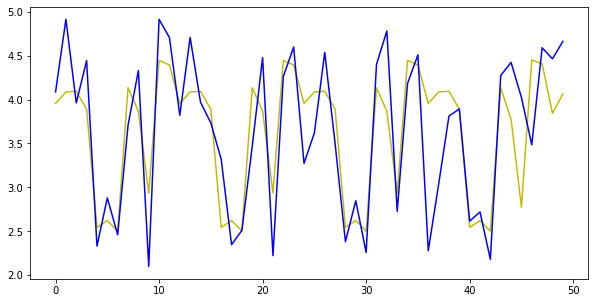

In [20]:
# testPred = testPred.cpu().numpy()
# testY = testY.cpu().numpy()
testPred = testPred.reshape((-1))
testY = testY.reshape((-1))
data_range = np.arange(100,150)
plt.figure(figsize =(10,5))
plt.plot(testPred[data_range],color = 'y')
plt.plot(testY[data_range],color ='b')
plt.show()


In [9]:
model= torch.load(model_file)
num_train, _, num_vertex = trainX.shape
num_val = valX.shape[0]
num_test = testX.shape[0]
train_num_batch = math.ceil(num_train / batch_size)
val_num_batch = math.ceil(num_val / batch_size)
test_num_batch = math.ceil(num_test / batch_size)

# test model
log_string(log, '**** testing model ****')
log_string(log, 'loading model from %s' % model_file)
model = torch.load(model_file)
log_string(log, 'model restored!')
log_string(log, 'evaluating...')

with torch.no_grad():
    trainPred = []
    for batch_idx in range(train_num_batch):
        start_idx = batch_idx * batch_size
        end_idx = min(num_train, (batch_idx + 1) * batch_size)
        X = trainX[start_idx: end_idx]
        TE = trainTE[start_idx: end_idx]
        pred_batch = model(X, TE)
        trainPred.append(pred_batch.detach().clone())
        del X, TE, pred_batch
    trainPred = torch.from_numpy(np.concatenate(trainPred, axis=0))
    trainPred = trainPred * std + mean

    valPred = []
    for batch_idx in range(val_num_batch):
        start_idx = batch_idx * batch_size
        end_idx = min(num_val, (batch_idx + 1) * batch_size)
        X = valX[start_idx: end_idx]
        TE = valTE[start_idx: end_idx]
        pred_batch = model(X, TE)
        valPred.append(pred_batch.detach().clone())
        del X, TE, pred_batch
    valPred = torch.from_numpy(np.concatenate(valPred, axis=0))
    valPred = valPred * std + mean

    testPred = []
    start_test = time.time()
    for batch_idx in range(test_num_batch):
        start_idx = batch_idx * batch_size
        end_idx = min(num_test, (batch_idx + 1) * batch_size)
        X = testX[start_idx: end_idx]
        TE = testTE[start_idx: end_idx]
        pred_batch = model(X, TE)
        testPred.append(pred_batch.detach().clone())
        del X, TE, pred_batch
    testPred = torch.from_numpy(np.concatenate(testPred, axis=0))
    testPred = testPred* std + mean
end_test = time.time()
train_mae, train_rmse, train_mape = metric(trainPred, trainY)
val_mae, val_rmse, val_mape = metric(valPred, valY)
test_mae, test_rmse, test_mape = metric(testPred, testY)
log_string(log, 'testing time: %.1fs' % (end_test - start_test))
log_string(log, '                MAE\t\tRMSE\t\tMAPE')
log_string(log, 'train            %.2f\t\t%.2f\t\t%.2f%%' %
           (train_mae, train_rmse, train_mape * 100))
log_string(log, 'val              %.2f\t\t%.2f\t\t%.2f%%' %
           (val_mae, val_rmse, val_mape * 100))
log_string(log, 'test             %.2f\t\t%.2f\t\t%.2f%%' %
           (test_mae, test_rmse, test_mape * 100))
log_string(log, 'performance in each prediction step')
MAE, RMSE, MAPE = [], [], []
for step in range(num_pred):
    mae, rmse, mape = metric(testPred[:, step], testY[:, step])
    MAE.append(mae)
    RMSE.append(rmse)
    MAPE.append(mape)
    log_string(log, 'step: %02d         %.2f\t\t%.2f\t\t%.2f%%' %
               (step + 1, mae, rmse, mape * 100))
average_mae = np.mean(MAE)
average_rmse = np.mean(RMSE)
average_mape = np.mean(MAPE)
log_string(
    log, 'average:         %.2f\t\t%.2f\t\t%.2f%%' %
         (average_mae, average_rmse, average_mape * 100))



NameError: name 'log' is not defined